In [1]:
%load_ext autoreload
%autoreload 2

In [152]:
import os
import subprocess
from tqdm import tqdm
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import librosa

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Data processing - wav conversion

In [4]:
data_path = os.path.join(os.getcwd(), '../public_dataset/public_dataset/')

In [8]:
# Convert all webm files to wav files

def convert_webm_to_wav(webm_file):
    wav_file = os.path.splitext(webm_file)[0] + '.wav'
    command = ['ffmpeg', '-i', webm_file, wav_file]
    subprocess.run(command)

In [9]:
# Multi-threaded conversion
import concurrent.futures

def convert_all_webm_to_wav(folder_path):
    webm_files = [file for file in os.listdir(folder_path) if file.endswith('.webm')]

    with concurrent.futures.ThreadPoolExecutor() as executor, tqdm(total=len(webm_files), desc="Converting") as pbar:
        futures = []

        for webm_file in webm_files:
            future = executor.submit(convert_webm_to_wav, os.path.join(folder_path, webm_file))
            future.add_done_callback(lambda p: pbar.update())
            futures.append(future)

        concurrent.futures.wait(futures)


In [10]:
convert_all_webm_to_wav(data_path)

Converting:   0%|          | 0/25985 [00:00<?, ?it/s]

Converting: 100%|██████████| 25985/25985 [04:59<00:00, 86.62it/s] 


In [12]:
# Delete all webm files

def delete_all_webm(folder_path):
    webm_files = [file for file in os.listdir(folder_path) if file.endswith('.webm')]

    for webm_file in webm_files:
        os.remove(os.path.join(folder_path, webm_file))

delete_all_webm(data_path)

In [11]:
# Get a random json file in the data path
json_file = os.path.join(data_path, np.random.choice(os.listdir(data_path)))

with open(json_file,'r') as f:
    content = json.loads(f.read())

print(content)

{'datetime': '2020-05-10T11:25:39.624938+00:00', 'cough_detected': '0.3891', 'latitude': '43.8', 'longitude': '-79.2'}


## Dataset

In [5]:
SAMPLE_RATE=22050
NUM_SAMPLES=22050
BATCH_SIZE=128
EPOCHS=20

In [6]:
import torchaudio as ta

melspectogram = ta.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE, n_fft=1024, hop_length=512, n_mels=64
)

In [7]:
from src.datasets import CoughDataset
from src.architecture.models import CoughMDN, CoughCNN
from src.training import train_loop, mdn_loss, test_loop

In [8]:
import torch
from torch.utils.data import DataLoader

In [15]:
cough_dataset = CoughDataset(
    data_path,
    data_path,
    transformation=melspectogram,
    target_sample_rate=SAMPLE_RATE,
    num_samples=NUM_SAMPLES,
    device="cuda",
)

In [18]:
from torch.utils.data.dataloader import default_collate

def skip_collate(batch):
    batch = list(filter(lambda x : x is not None, batch))
    return default_collate(batch)


In [19]:
# Create a train and test split data loader
# train_size = int(0.8 * len(cough_dataset))
# test_size = len(cough_dataset) - train_size

# train_dataset, test_dataset = torch.utils.data.random_split(cough_dataset, [train_size, test_size])

# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

subset_size = int(0.2 * len(cough_dataset))

# Randomly sample 5% of the dataset
subset_dataset, _ = torch.utils.data.random_split(cough_dataset, [subset_size, len(cough_dataset) - subset_size])

# Split the subset into train and test
train_size = int(0.8 * subset_size)
test_size = subset_size - train_size

train_subset, test_subset = torch.utils.data.random_split(subset_dataset, [train_size, test_size])

# Create DataLoader for train and test subsets
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=skip_collate)
test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=skip_collate)


In [20]:
for waveform,label in train_loader:
    print(label.shape, waveform.shape)
    break

torch.Size([64, 1]) torch.Size([64, 1, 64, 44])


In [21]:
len(train_loader), len(test_loader)

(33, 9)

In [23]:
cough_model = CoughMDN(n_mixtures=3).cuda()

In [24]:
optimizer = torch.optim.Adam(cough_model.parameters(), lr=0.01)

train_losses_adam = []
test_losses_adam = []

progress_bar = tqdm(range(EPOCHS))
for _ in progress_bar:
    train_losses_adam.append(
        train_loop(
            cough_model,
            train_loader,
            optimizer,
            loss_function=mdn_loss,
            device=device,
        )
    )

    test_losses_adam.append(
        test_loop(cough_model, test_loader, loss_function=mdn_loss, device=device)
    )

    progress_bar.set_description(
        f"Train loss: {train_losses_adam[-1]:.4f}, Test loss: {test_losses_adam[-1]:.4f}"
    )

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 16.5032, Test loss: 16.1390:   5%|▌         | 1/20 [02:00<38:10, 120.54s/it]

Train loss: 16.2678, Test loss: 16.1783:  10%|█         | 2/20 [02:23<18:58, 63.27s/it] 

Train loss: 16.2001, Test loss: 15.9489:  15%|█▌        | 3/20 [02:45<12:31, 44.19s/it]

Train loss: 15.4862, Test loss: 14.1486:  20%|██        | 4/20 [03:07<09:26, 35.40s/it]

Train loss: 10.1768, Test loss: 7.4033:  25%|██▌       | 5/20 [03:29<07:39, 30.63s/it] 

Train loss: 6.2805, Test loss: 6.0176:  30%|███       | 6/20 [03:50<06:23, 27.40s/it] 

Train loss: 5.6597, Test loss: 5.4569:  35%|███▌      | 7/20 [04:11<05:29, 25.33s/it]

Train loss: 5.4653, Test loss: 5.2896:  40%|████      | 8/20 [04:33<04:52, 24.34s/it]

Train loss: 5.3260, Test loss: 5.2505:  45%|████▌     | 9/20 [04:55<04:19, 23.57s/it]

Train loss: 5.3207, Test loss: 5.1310:  50%|█████     | 10/20 [05:17<03:50, 23.02s/it]

Train loss: 5.2374, Test loss: 5.4692:  55%|█████▌    | 11/20 [05:40<03:26, 22.96s/it]

Train loss: 5.1966, Test loss: 5.1319:  60%|██████    | 12/20 [06:06<03:12, 24.02s/it]

Train loss: 5.1479, Test loss: 5.1613:  65%|██████▌   | 13/20 [06:30<02:46, 23.82s/it]

Train loss: 5.1100, Test loss: 5.0939:  70%|███████   | 14/20 [06:53<02:21, 23.65s/it]

Train loss: 5.0905, Test loss: 5.0107:  75%|███████▌  | 15/20 [07:14<01:55, 23.05s/it]

Train loss: 5.0467, Test loss: 4.9817:  80%|████████  | 16/20 [07:36<01:30, 22.73s/it]

Train loss: 5.0306, Test loss: 4.9615:  85%|████████▌ | 17/20 [08:00<01:08, 22.83s/it]

Train loss: 5.0075, Test loss: 4.9322:  90%|█████████ | 18/20 [08:22<00:45, 22.62s/it]

Train loss: 5.0043, Test loss: 4.9475:  95%|█████████▌| 19/20 [08:44<00:22, 22.46s/it]

Train loss: 4.9871, Test loss: 4.9329: 100%|██████████| 20/20 [09:06<00:00, 27.32s/it]


In [25]:
cough_model_cnn = CoughCNN().cuda()

In [26]:
optimizer_cnn = torch.optim.Adam(cough_model_cnn.parameters(), lr=0.01)

train_losses_cnn = []
test_losses_cnn = []

mse_loss = torch.nn.MSELoss()

progress_bar = tqdm(range(EPOCHS))
for _ in progress_bar:
    train_losses_cnn.append(
        train_loop(
            cough_model_cnn,
            train_loader,
            optimizer_cnn,
            loss_function=mse_loss,
            device=device,
        )
    )

    test_losses_cnn.append(
        test_loop(cough_model_cnn, test_loader, loss_function=mse_loss, device=device)
    )

    progress_bar.set_description(
        f"Train loss: {train_losses_cnn[-1]:.4f}, Test loss: {test_losses_cnn[-1]:.4f}"
    )

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 1496.9666, Test loss: 1452.4431:   5%|▌         | 1/20 [00:22<07:07, 22.49s/it]

Train loss: 1497.0255, Test loss: 1452.4431:  10%|█         | 2/20 [00:43<06:32, 21.80s/it]

Train loss: 1500.3253, Test loss: 1452.4431:  15%|█▌        | 3/20 [01:04<06:04, 21.42s/it]

Train loss: 1496.6627, Test loss: 1452.4431:  20%|██        | 4/20 [01:25<05:38, 21.18s/it]

Train loss: 1496.6339, Test loss: 1452.4431:  25%|██▌       | 5/20 [01:46<05:15, 21.01s/it]

Train loss: 1496.8716, Test loss: 1452.4431:  30%|███       | 6/20 [02:07<04:52, 20.92s/it]

Train loss: 1495.4798, Test loss: 1452.4431:  35%|███▌      | 7/20 [02:28<04:33, 21.04s/it]

Train loss: 1499.1412, Test loss: 1452.4431:  40%|████      | 8/20 [02:49<04:14, 21.19s/it]

Train loss: 1508.0392, Test loss: 1452.4431:  45%|████▌     | 9/20 [03:11<03:53, 21.24s/it]

Train loss: 1497.1232, Test loss: 1452.4431:  50%|█████     | 10/20 [03:32<03:33, 21.34s/it]

Train loss: 1498.8198, Test loss: 1452.4431:  55%|█████▌    | 11/20 [03:54<03:13, 21.50s/it]

Train loss: 1493.4166, Test loss: 1452.4431:  60%|██████    | 12/20 [04:16<02:52, 21.55s/it]

Train loss: 1504.0724, Test loss: 1452.4431:  65%|██████▌   | 13/20 [04:36<02:27, 21.04s/it]

Train loss: 1503.3487, Test loss: 1452.4431:  70%|███████   | 14/20 [04:55<02:03, 20.61s/it]

Train loss: 1498.3305, Test loss: 1452.4431:  75%|███████▌  | 15/20 [05:15<01:41, 20.34s/it]

Train loss: 1500.5519, Test loss: 1452.4431:  80%|████████  | 16/20 [05:34<01:20, 20.03s/it]

Train loss: 1507.2477, Test loss: 1452.4431:  85%|████████▌ | 17/20 [05:55<01:00, 20.29s/it]

Train loss: 1504.3920, Test loss: 1452.4431:  90%|█████████ | 18/20 [06:15<00:40, 20.24s/it]

Train loss: 1498.2157, Test loss: 1452.4431:  95%|█████████▌| 19/20 [06:35<00:20, 20.10s/it]

Train loss: 1497.4622, Test loss: 1452.4431: 100%|██████████| 20/20 [06:55<00:00, 20.78s/it]


In [27]:
# Save the model

torch.save(cough_model.state_dict(), 'cough_age_model.pt')
torch.save(cough_model_cnn.state_dict(), 'cough_age_model_cnn.pt')

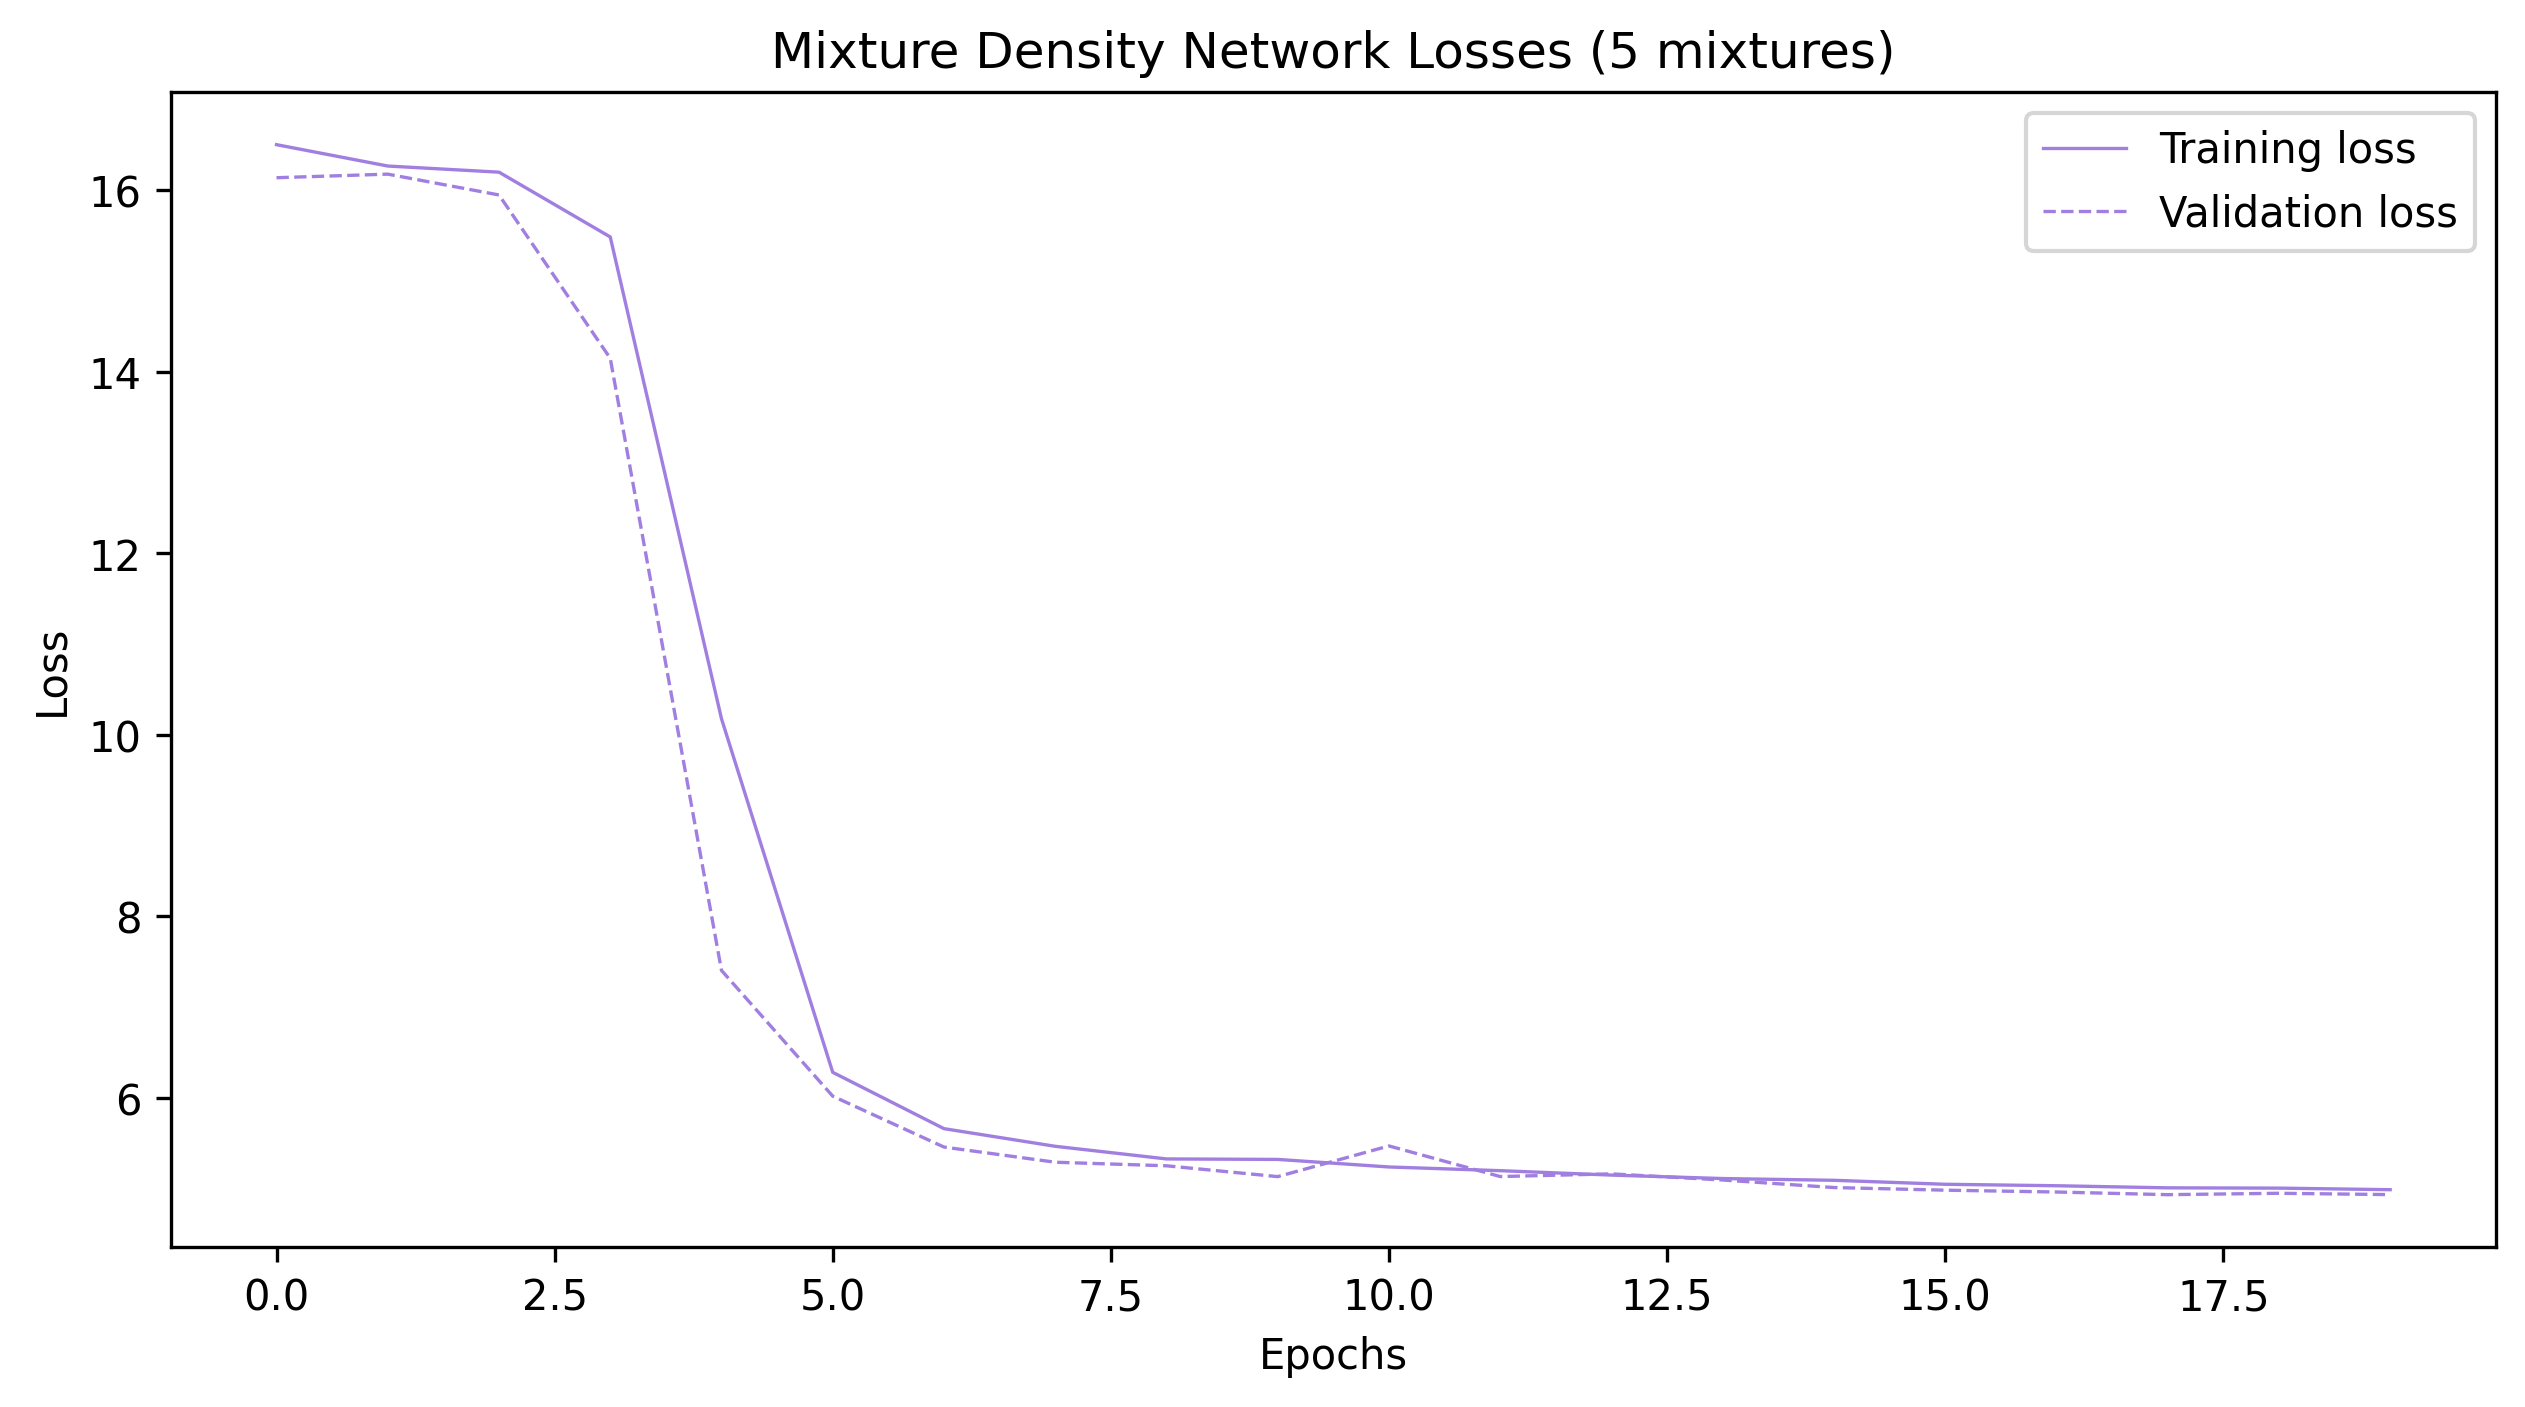

In [28]:
plt.figure(figsize=(10, 5), dpi=300)

plt.plot(train_losses_adam, label="Training loss", linewidth=0.8, color="#a17fe0")
plt.plot(test_losses_adam, label="Validation loss", linewidth=0.8, color="#a17fe0", linestyle="--")
plt.legend()
plt.title("Mixture Density Network Losses (5 mixtures)")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.savefig("src/images/losses_cough.png", dpi=300, transparent=True)

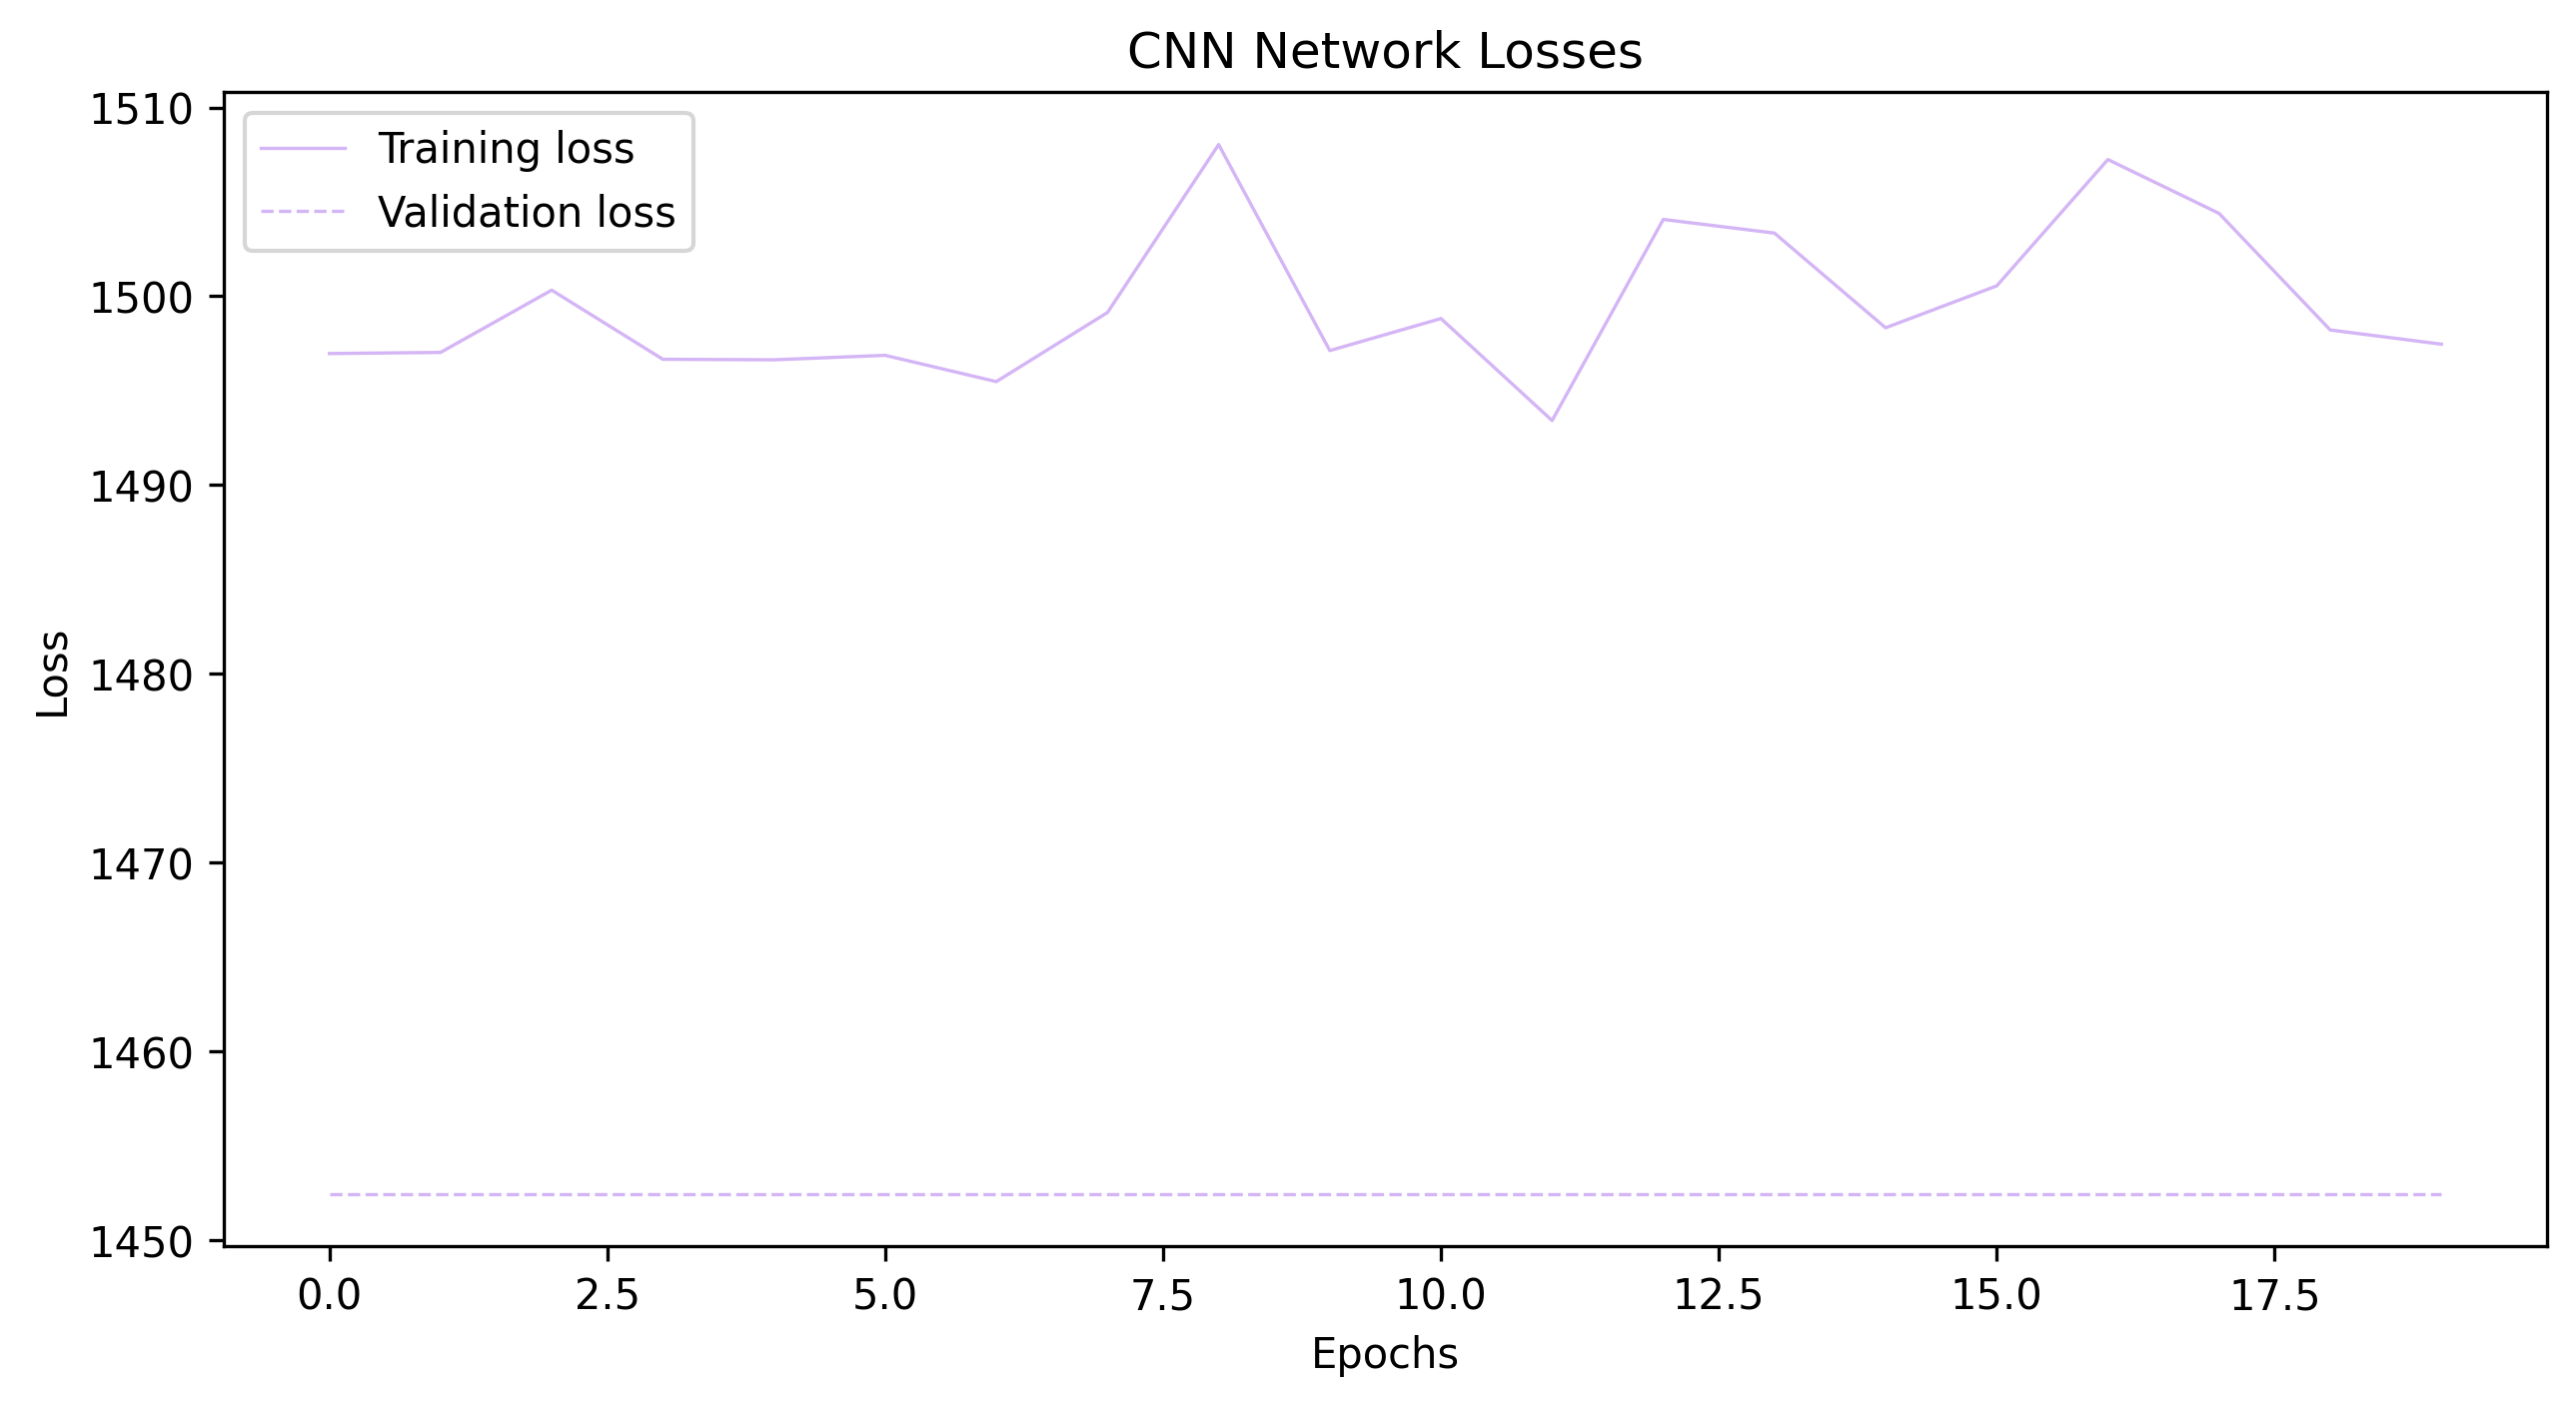

In [29]:
plt.figure(figsize=(10, 5), dpi=300)

plt.plot(train_losses_cnn, label="Training loss", linewidth=0.8, color="#d4b5f5")
plt.plot(test_losses_cnn, label="Validation loss", linewidth=0.8, color="#d4b5f5", linestyle="--")
plt.legend()
plt.title("CNN Network Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.savefig("src/images/losses_cough_cnn.png", dpi=300, transparent=True)

In [30]:
# Get mu, sigma and pi from the test_loader
mu, sigma, pi = [], [], []
for waveform, label in test_loader:
    waveform = waveform.cuda()
    label = label.cuda()

    mu_, sigma_, pi_ = cough_model(waveform)

    mu.append(mu_.detach().cpu().numpy())
    sigma.append(sigma_.detach().cpu().numpy())
    pi.append(pi_.detach().cpu().numpy())

mu = np.concatenate(mu)
sigma = np.concatenate(sigma)
pi = np.concatenate(pi)

In [31]:
mu.shape, sigma.shape, pi.shape

((564, 3, 1), (564, 3), (564, 3))

In [112]:
true_labels = []
for sample in test_loader.dataset:
    if sample is not None:
        true_labels.append(int(sample[1][0]))
true_labels = np.array(true_labels)

In [103]:
indices = torch.arange(mu.shape[0])
mu_max = mu[indices, np.argmax(pi, axis=1)]

In [104]:
# Compute MSE loss between true labels and mu_max

mse_loss = torch.nn.MSELoss()
mdn_error = mse_loss(torch.tensor(mu_max), torch.tensor(true_labels))

c:\Users\Antoine\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([564])) that is different to the input size (torch.Size([564, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [105]:
# Compute MSE loss between true labels and the cough_model_cnn predictions

cough_model_cnn.eval()

cnn_predictions = []
for waveform, label in test_loader:
    waveform = waveform.cuda()
    label = label.cuda()

    cnn_predictions.append(cough_model_cnn(waveform).detach().cpu().numpy())

cnn_predictions = np.concatenate(cnn_predictions)

cnn_error = mse_loss(torch.tensor(cnn_predictions), torch.tensor(true_labels))

In [106]:
print(f"MDN error: {mdn_error:.4f}, CNN error: {cnn_error:.4f}")

MDN error: 1141.9073, CNN error: 1481.2714


In [107]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [142]:
# Get samples of the test_loader with label between 0.4 and 0.5

def plot_range(min_range, max_range, num=10, mixtures=3):
    indices = np.where((true_labels >= min_range) & (true_labels <= max_range))[0]
    indices = [idx for idx in indices if test_loader.dataset[idx] is not None]
    print(f"Found {len(indices)} samples in the range {min_range} - {max_range}")
    indices = np.random.choice(indices, num)
    indices = np.unique(indices)
    samples = [test_loader.dataset[i] for i in indices]
    # Add true label to each sample
    samples = [(sample[0], sample[1], true_labels[i], idx) for i, (sample, idx) in enumerate(zip(samples, indices))]
    samples = sorted(samples, key=lambda x: x[1])

    palette = plt.cm.viridis(np.linspace(0, 1, mixtures))

    fig, ax = plt.subplots(figsize=(20, 10), dpi=300)

    for i in range(len(samples)):
        waveform, label, true_label, idx = samples[i]

        waveform = waveform.cuda()
        label = label.cuda()

        mu_, sigma_, pi_ = cough_model(waveform.unsqueeze(0))
        pi_values = pi_.detach().cpu().numpy().squeeze()

        x_values = [i for _ in range(len(pi_values))]
        ax.scatter(x_values, pi_values, label=f"Sample {i}", color=palette)

    # Set x-axis ticks to the index of each sample
    ax.set_xticks(np.arange(len(samples)))
    ax.set_xticklabels([f"{int(samples[i][1][0])} / {samples[i][2]} ({samples[i][3]})" for i in range(len(samples))])

    plt.legend(handles=[mpatches.Patch(color=palette[i], label=f"Mixture {i}") for i in range(mixtures)])

    # Set labels and title
    ax.set_xlabel('Age')
    ax.set_ylabel('Pi Values')
    ax.set_title('Pi Values for Each Sample')

    plt.show()


Found 81 samples in the range 0.0 - 25


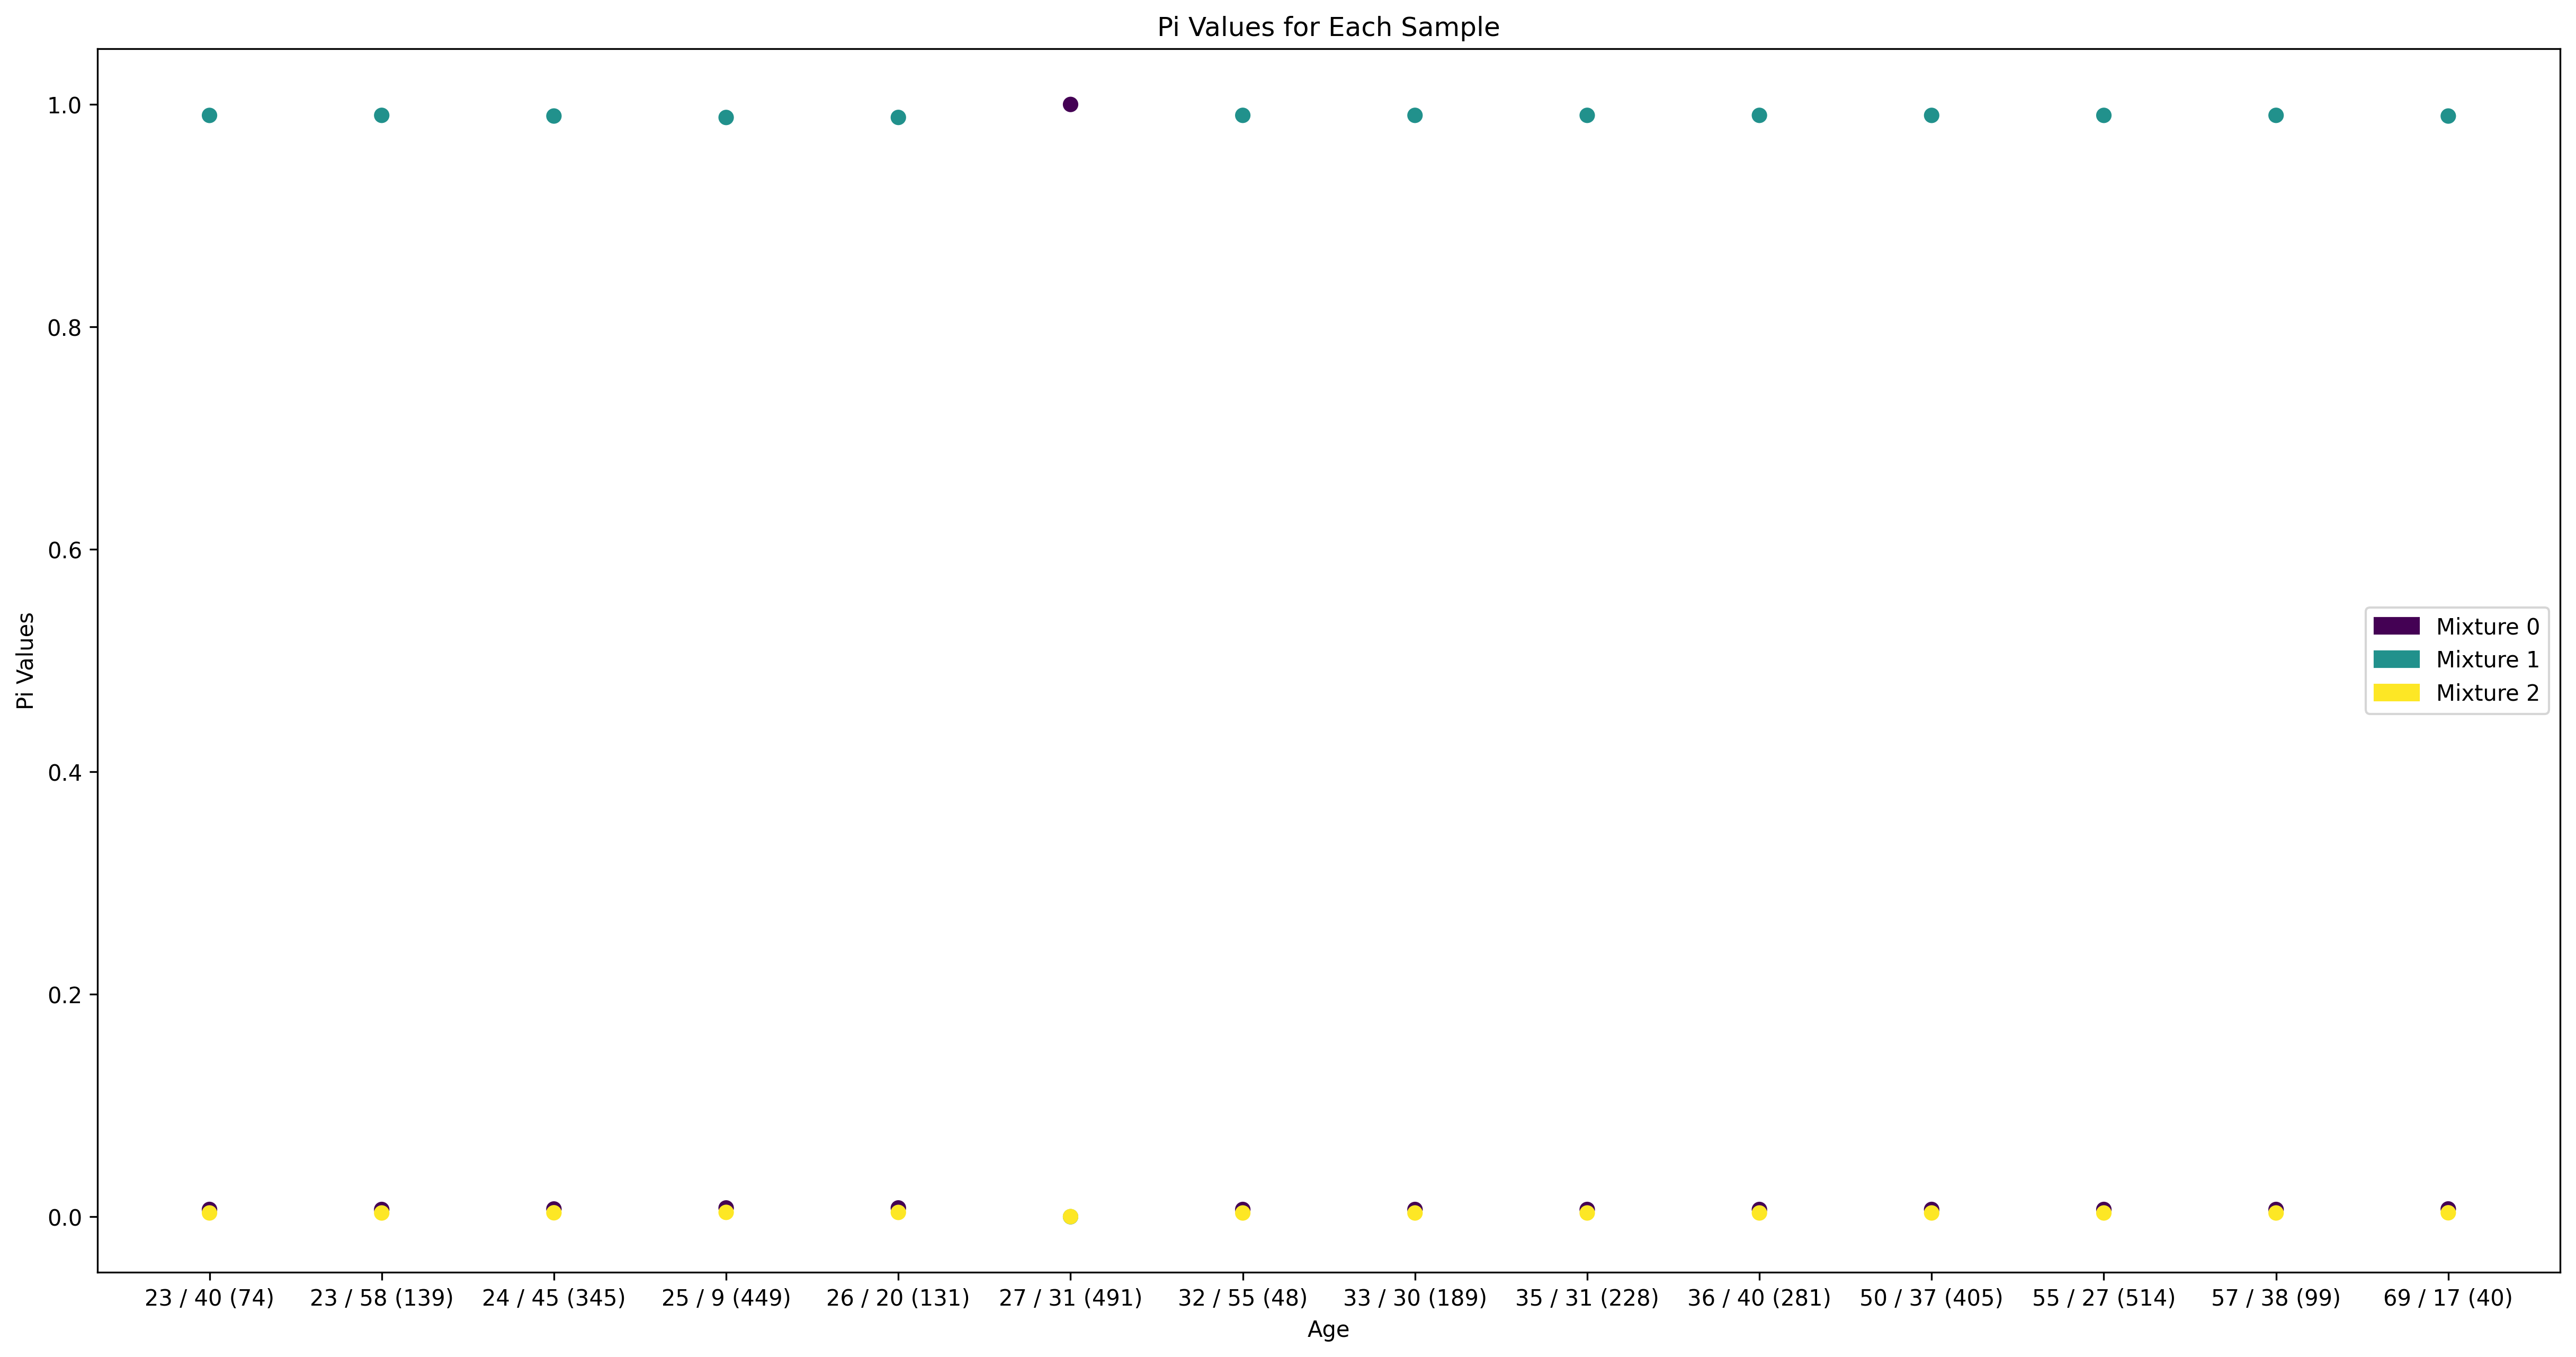

In [143]:
plot_range(0.0, 25, num=15)

Found 53 samples in the range 25 - 30


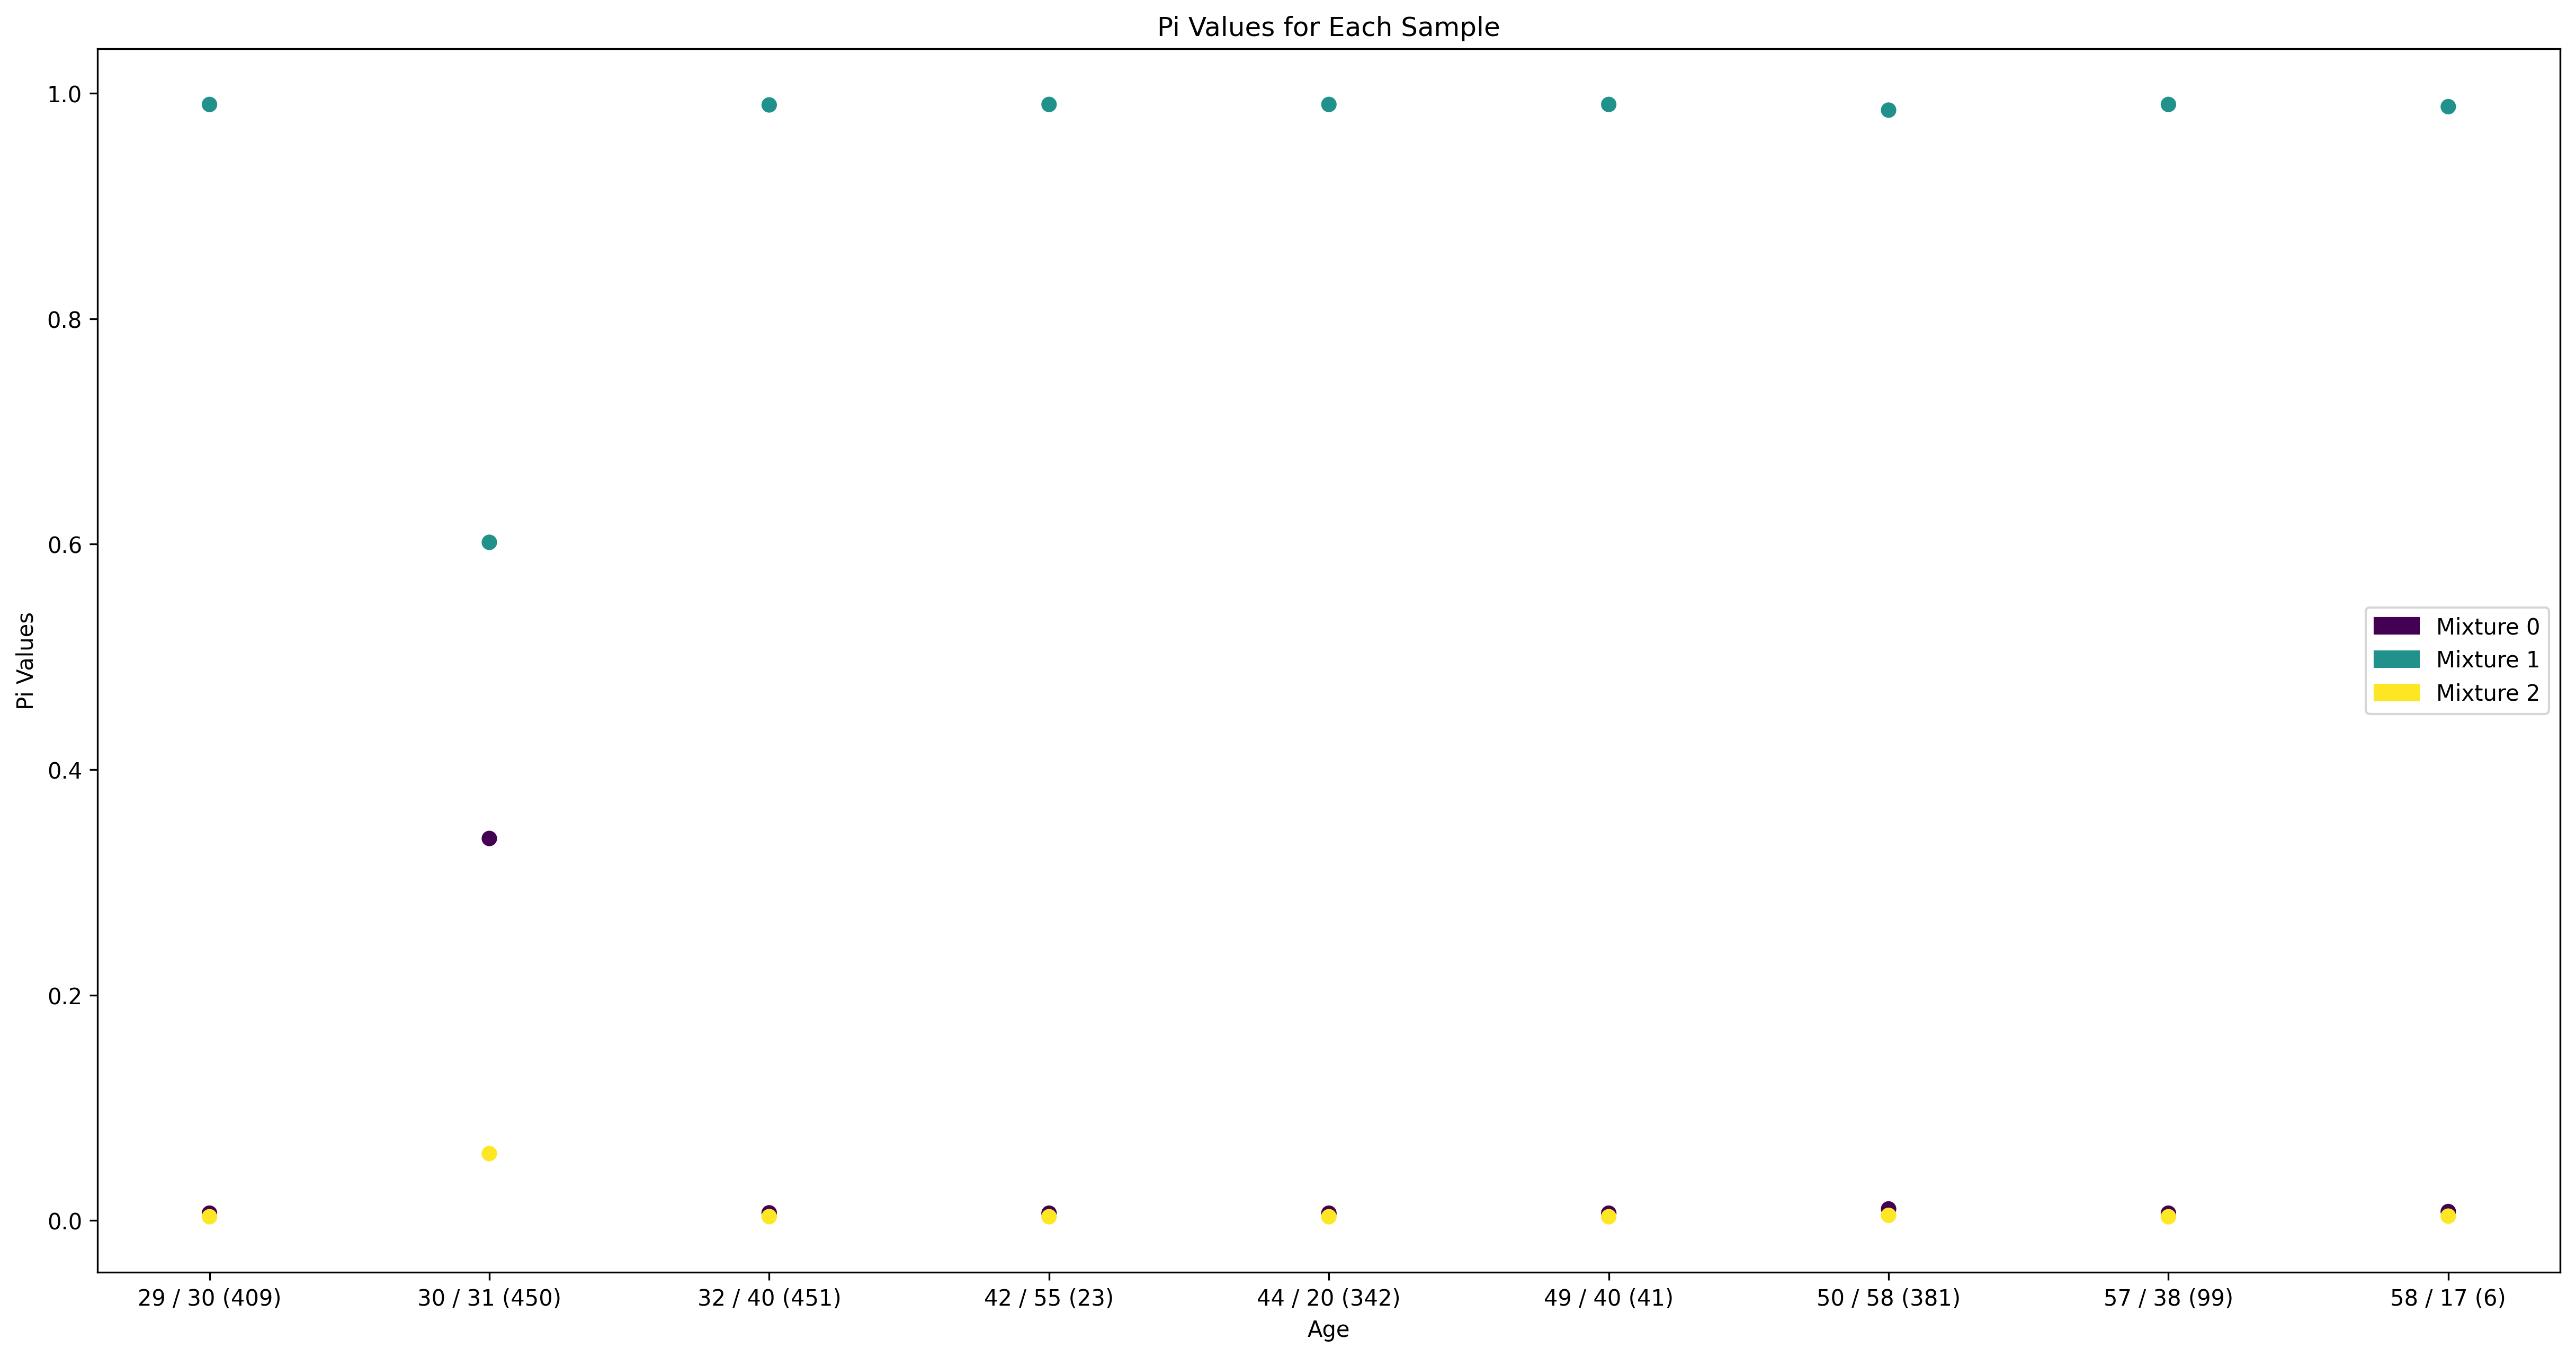

In [144]:
plot_range(25, 30, num=10)

In [151]:
waveform, label = test_loader.dataset[450]

plt.figure(figsize = (16, 6))
librosa.display.waveshow(y = waveform, sr = SAMPLE_RATE)
plt.title("Sound Waves in Reggae 36", fontsize = 23)


ImportError: Numba needs NumPy 1.20 or less

<Figure size 1600x600 with 0 Axes>